In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl

mpl_config = pd.read_csv('../../mpl_config.csv').to_dict(orient='records')[0]

mpl.rcParams.update(mpl_config)

In [4]:
def produce_trial_index(d) :
    """Produce a dictionnary of trial indices corresponding to each label."""
    
    trial_idx = None
    
    go_hit_idx = (d['Choice'] == 1)&(d['Category ID'] == 1)&(d['Context'] == 0)
    go_error_idx = (d['Choice'] == 1)&(d['Category ID'] == 0)&(d['Context'] == 0)

    nogo_hit_idx = (d['Choice'] == 0)&(d['Category ID'] == 0)&(d['Context'] == 0)
    nogo_error_idx = (d['Choice'] == 0)&(d['Category ID'] == 1)&(d['Context'] == 0)

    go2_hit_idx = (d['Choice'] == 1) & (d['Category ID'] == 1)&(d['Context'] == 1)
    nogo2_hit_idx = (d['Choice'] == 0) & (d['Category ID'] == 0)&(d['Context'] == 1)

    go2_error_idx = (d['Choice'] == 1) & (d['Category ID'] == 0)&(d['Context'] == 1)
    nogo2_error_idx = (d['Choice'] == 0) & (d['Category ID'] == 1)&(d['Context'] == 1)

    trial_idx = {'T5 : Go / Go : Hit' : go_hit_idx, 'T5 : Go / Nogo : Miss':nogo_error_idx, 'T5 : NoGo / NoGo : CR' : nogo_hit_idx , \
              'T5 : NoGo / Go : FA' : go_error_idx,  'T8 : Go / Go : Hit' : go2_hit_idx, 'T8 : Go / Nogo : Miss':nogo2_error_idx, 'T8 : NoGo / NoGo : CR' : nogo2_hit_idx , \
              'T8 : NoGo / Go : FA' : go2_error_idx}

    
    return trial_idx

def generate_column_label(d) :
    
    trial_idx = produce_trial_index(d)


    # Add corresponding labels to trial in each DataFrame.
    #labels = [k for k in range(1,9)]

    condition = 1
    trial_label = np.zeros(len(d))
    for idx in trial_idx.values() :
        trial_label += idx*condition
        condition += 1

    if 'Label' not in d :
        d.insert(6, 'Label', trial_label)
    # Add a column 'Label' to full DataFrames
    # 1 : Go / Go Hit,  2 : Go / Nogo : Miss,   3 :NoGo / NoGo : CR , 4: NoGo / Go : FA
    # Stimuli category / Animal response
    

In [10]:
files = ['M01','M02','M03','M04','M05','M07_Region1','M07_Region2','M08_Region1','M08_Region2',\
       'M09_Region1','M09_Region2','M10_Region1','M11_Region1','M11_Region2']

with open('../DATA/Dataframes/df_full.pickle', 'rb') as f:
    data_full = pickle.load(f)

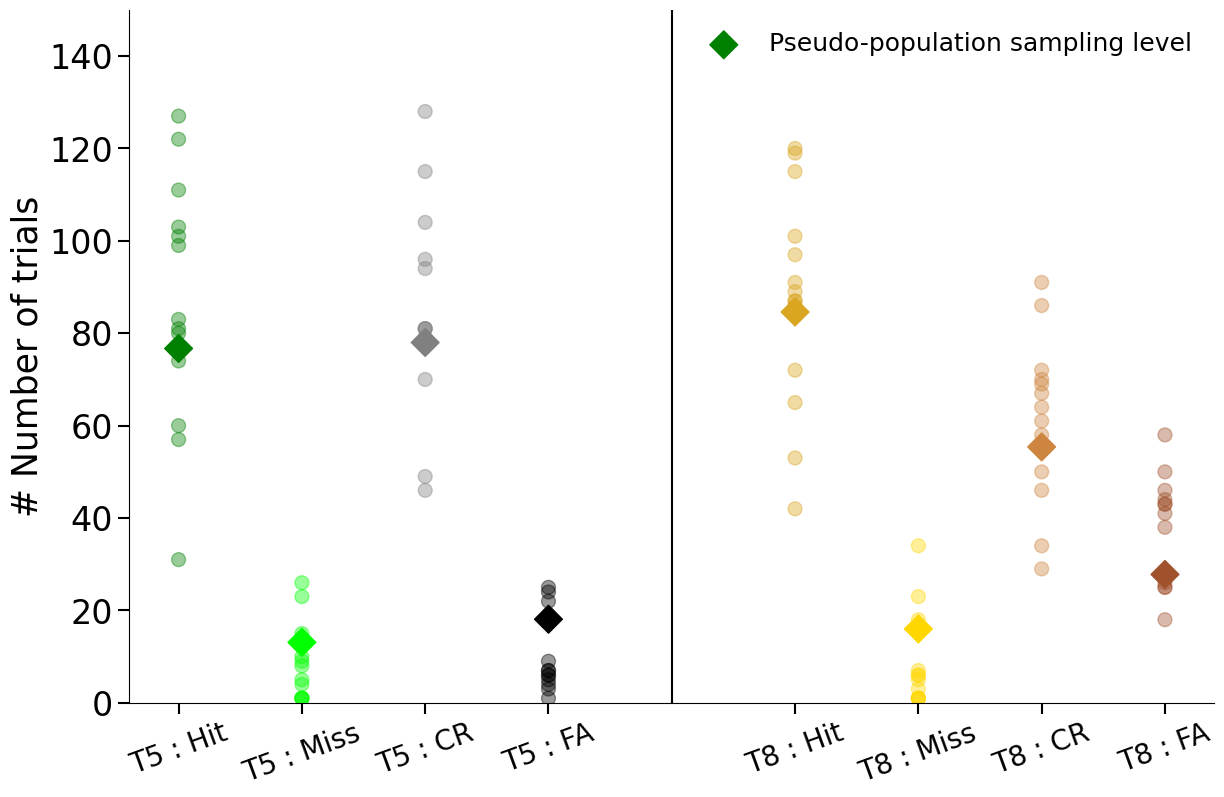

In [33]:
files_to_merge = files

all_rates = [[data_full[f]['Spike rate'][data_full[f]['Label'] == i] for i in range(1,9)] for f in files_to_merge]

plt.figure(figsize=(14,9))

colors = ['green', 'lime','grey','black','goldenrod','gold','peru','sienna']



nb_per_cond = []
for rate in all_rates :
    nb_per_cond_mouse = []
    for k in range(len(rate)) :
         nb_per_cond_mouse.append(len(rate[k]))
    plt.scatter([k for k in range(4)] + [k for k in range(5,9)],nb_per_cond_mouse, color = colors, alpha = 0.4, s=100)
    nb_per_cond.append(nb_per_cond_mouse)
    
nb_per_cond = np.array(nb_per_cond)
aim = np.percentile(nb_per_cond,30,axis=0)
aim[[1,3,5]] = np.percentile(nb_per_cond[:,[1,3,5]],70,axis=0)


plt.scatter([k for k in range(4)] + [k for k in range(5,9)],aim,marker='D',s=200, color = colors, alpha=1, label='Pseudo-population sampling level')

cond_names = ['T5 : Hit' ,'T5 : Miss' ,'T5 : CR', 'T5 : FA',  \
          'T8 : Hit', 'T8 : Miss','T8 : CR','T8 : FA']

plt.legend(frameon=False,fontsize=18)
plt.ylabel('# Number of trials')
plt.ylim((0,150))
plt.xticks([k for k in range(4)] + [k for k in range(5,9)],cond_names,rotation=20,fontsize=20)
plt.vlines(4, ymin = 0, ymax = 150, linestyle = '-', color = 'black')

plt.savefig('Plots/SVG/pseudopop_nbtrials.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/pseudopop_nbtrials.PNG', dpi = 300,bbox_inches='tight')

In [87]:
np.random.seed(77)

# Sampled_rates refers to mean neural activity on post stimulus period
sampled_rates = []
for rate in all_rates :
    sampled_rates_mouse = []
    for k in range(len(rate)) :
        nb_trials = len(rate[k])
        sample_size = int(aim[k])
        sample = np.random.choice(range(len(rate[k])),sample_size, replace = True)
        
        sampled_rates_mouse.append([(rate[k].to_numpy())[idx] for idx in sample])
        
    sampled_rates.append(sampled_rates_mouse)


In [89]:
## We build here a dataframe for pseudo-population data, reinserting the exact condition for each trial.
context_value = [0,0,0,0,1,1,1,1]
cat_value = [1,1,0,0,1,1,0,0]
choice_value = [1,0,0,1,1,0,0,1]
motor_value = [1,0,0,1,1,0,0,1]
reward_value = [1,0,0,0,1,0,0,0]


context_label = []
cat_label = []
choice_label = []
motor_label = []
reward_label = []
for k in range(len(context_value)) :
    for _ in range(int(aim[k])) : 
        context_label.append(context_value[k])
        cat_label.append(cat_value[k])
        choice_label.append(choice_value[k])
        motor_label.append(motor_value[k])
        reward_label.append(reward_value[k])

merged_rates_cond = []
for k in range(len(context_value)) :
    rates = np.concatenate([np.stack(sampled_rates[f][k]) for f in range(len(files_to_merge))],axis=1)
    merged_rates_cond.append(rates)
    
merged_rates = np.concatenate([merged_rates_cond[k] for k in range(len(context_value))],axis=0)

builder = {'Category ID' : cat_label, 'Choice' : choice_label,'Motor action' : motor_label, 'Context' : context_label, 'Spike rate' : [merged_rates[i] for i in range(len(merged_rates))], 'Reward' : reward_label}

merged_data = pd.DataFrame(builder)

In [91]:
trial_idx = produce_trial_index(merged_data)
generate_column_label(merged_data)

In [92]:
merged_data.groupby(['Label']).count()

,Category ID,Choice,Motor action,Context,Spike rate,Reward
Label,,,,,,
1.0,76,76,76,76,76,76
2.0,13,13,13,13,13,13
3.0,78,78,78,78,78,78
4.0,18,18,18,18,18,18
5.0,84,84,84,84,84,84
6.0,16,16,16,16,16,16
7.0,55,55,55,55,55,55
8.0,27,27,27,27,27,27


In [96]:
with open('../DATA/Dataframes/df_pseudo.pickle', 'wb') as f:
    pickle.dump(merged_data,f)